---
title: Creating Timeseries with NLDAS-3 Sample Data
author: Rishi Anand, Siddharth Chaudhary
date: August 5, 2024
execute:
   freeze: true
---

## Run this notebook

You can launch this notebook in VEDA JupyterHub by clicking the link below.

[Launch in VEDA JupyterHub (requires access)](https://hub.openveda.cloud/hub/user-redirect/git-pull?repo=https://github.com/NASA-IMPACT/veda-docs&urlpath=lab/tree/veda-docs/user-guide/notebooks/datasets/nldas_time_series.ipynb&branch=main) 

<details><summary>Learn more</summary>
    
### Inside the Hub

This notebook was written on the VEDA JupyterHub and as such is designed to be run on a jupyterhub which is associated with an AWS IAM role which has been granted permissions to the VEDA data store via its bucket policy. The instance used provided 16GB of RAM. 

See (VEDA Analytics JupyterHub Access)[https://nasa-impact.github.io/veda-docs/veda-jh-access.html] for information about how to gain access.

### Outside the Hub

The data is in a protected bucket. Please request access by emailng aimee@developmentseed.org or alexandra@developmentseed.org and providing your affiliation, interest in or expected use of the dataset and an AWS IAM role or user Amazon Resource Name (ARN). The team will help you configure the cognito client.

You should then run:

```
%run -i 'cognito_login.py'
```
    
</details>

## About the Data

NLDAS is a widely used land modeling environment that generates
estimates of land surface fluxes and states such as soil moisture,
snow, and streamflow.  These estimates are critical for drought
and flood monitoring, water availability and water resource
management, climate assessments, and other uses.  NLDAS-3 is
the next generation version of NLDAS-2, and offers significant
improvements such as improved spatial resolution (12.5km to 1km),
expanded domain (CONUS to North and Central America), reduced
data latency (3.5 days to near real-time), and assimilation of
NASA remote sensing data, among others. (see [Earthdata VEDA Data
Story](https://www.earthdata.nasa.gov/dashboard/stories/nldas)). Please note that the NLDAS-3 precipitation data provided here
is a sample dataset still in development, and will not be the final NLDAS-3 product when it is released.
 
This notebook is intended to visualize the sample NLDAS-3 monthly-averaged precipitation forcing data via a timeseries.

### Using the VEDA STAC to Create a Timeseries
If you need to do analysis over an AOI you can do so via Project VEDA's STAC.

### Approach
1. Define the URL where the data is stored.
2. Make sure the dataset is the size we expected.
3. Define an Area of Interest.
4. Retrieve the dataset's statistics for the AOI.
5. Plot the relevant statistic.

In [1]:
# Import the following libraries
import requests
import json
import folium
import folium.plugins
import shapely

import pandas as pd
import matplotlib.pyplot as plt
from pystac.client import Client

## Querying the STAC API

The metadata and derived data products can be accessed without credentials via STAC API and Raster API respectively.

In [2]:
STAC_API_URL = "https://openveda.cloud/api/stac"
RASTER_API_URL = "https://openveda.cloud/api/raster"

The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable. 

Note: You can discover available collections via the STAC Browser: http://openveda.cloud

In [3]:
collection_id = "nldas3"

Use `pystac_client` to search the STAC collection for that collection.

In [4]:
catalog = Client.open(STAC_API_URL)
    
search = catalog.search(collections=[collection_id], limit=300)

item_collection = search.item_collection()
print(f"Found {len(item_collection)} items")

Found 252 items


## Define an AOI

Let's create a bounding box to explore the area of interest (AOI) in Texas. In this example we will use geojson to construct a `Polygon` geometry representing the bounding box. For bounding boxes it is often simpler to use a bounding box (list of 4 floats) instead. This example  demonstrates how you can construct more complicated geometries.

In [5]:
texas_dallas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-96.1, 32.28],  # Southeast Bounding Coordinate
                [-96.1, 33.28],  # Northeast Bounding Coordinate
                [-97.58, 33.28], # Northwest Bounding Coordinate
                [-97.58, 32.28],  # Southwest Bounding Coordinate
                [-96.1, 32.28]   # Closing the polygon at the Southeast Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}

Let's visualize the AOI we have just created using `folium` 

In [6]:
aoi_map = folium.Map(
    tiles="OpenStreetMap",
    location=[32.81,-96.93], # centered on Dallas, Texas area
    zoom_start=9, # zoom in or out by increasing or decreasing the value here
)

folium.GeoJson(texas_dallas_aoi, name="Texas, Dallas").add_to(aoi_map)

aoi_map

## Add the AOI to the STAC Query

Use shapely to construct a bounding box from the defined polygon and include that in the STAC search parameters.

In [7]:
bbox = shapely.from_geojson(json.dumps(texas_dallas_aoi)).bounds

search = catalog.search(collections=[collection_id], bbox=bbox, limit=300)

item_collection = search.item_collection()
print(f"Found {len(item_collection)} items")

Found 252 items


<div class="alert alert-block alert-info">

Note in this case we got the same number of items as before. This means that all the items in the catalog overlap the bounding box in question. So in this case it wasn't strictly necessary to add the bbox to the search parameters, but it is still best practice to do as much filtering as possible at every step to minimize data transfer and compute requirements.

</div>

Now let's take a closer look at one of these items:

In [8]:
item_collection[0]

<Item id=nldas3_LIS_HIST_202112>

## Get statistics with the Raster API

Create a function that retrieves information regarding a specific granule (an item) using its asset name and raster identifier and generates the statistics for it.

This function will make a POST request to the Raster API to submit the data associated with the item of interest (specific observation) within the Dallas, TX boundaries to compute its statistics. 

In [9]:
def generate_stats(item, geojson):
    """ For a given item and geojson, return a dictionary containing the computed 
    statistics along with the item's datetime information
    """
    response = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item.assets["cog_default"].href},
        json=geojson,
    )

    # If anything goes wrong with this request, output error contents
    assert response.ok, response.text

    result = response.json()

    return {
        **result["properties"]["statistics"]["b1"],
        "datetime": item.properties["end_datetime"],
    }

Let's try our new function out with just one item. We'll use `%%time` to see how long it takes to run.

In [10]:
%%time

generate_stats(item_collection[0], texas_dallas_aoi)

CPU times: user 4.92 ms, sys: 341 µs, total: 5.26 ms
Wall time: 405 ms


{'min': 5.5441460609436035,
 'max': 40.02827072143555,
 'mean': 18.9648380279541,
 'count': 925.0999755859375,
 'sum': 17544.37109375,
 'std': 7.4039084036512905,
 'median': 18.58078956604004,
 'majority': 5.5441460609436035,
 'minority': 5.5441460609436035,
 'unique': 964.0,
 'histogram': [[72, 155, 139, 161, 148, 120, 76, 56, 22, 15],
  [5.5441460609436035,
   8.992558479309082,
   12.440971374511719,
   15.889383316040039,
   19.33779525756836,
   22.78620719909668,
   26.234621047973633,
   29.683032989501953,
   33.131446838378906,
   36.579856872558594,
   40.02827072143555]],
 'valid_percent': 97.57,
 'masked_pixels': 24.0,
 'valid_pixels': 964.0,
 'percentile_2': 6.959613800048828,
 'percentile_98': 35.4062614440918,
 'datetime': '2021-12-31T00:00:00+00:00'}

This took about 0.5 seconds which means if we run it on every item in the collection we should expect it to take about 2 minutes.

We can run it that way if we want. It'll look like:

### Speed things up: parallelize computation with Dask

We can drastically reduce the time it takes to generate the timeseries, by parallelizing our code. The `cogs/statistics` API is powered by AWS Lambda which executes each request in a separate instance. This means the requests are highly scalable. Since each statistics request is for a single timestamp, we can request statistics for multiple timesteps concurrently, and greatly reduce the amount of time needed. We will demonstrate this by using the Dask.

#### Submit work

First we will create a Dask client. In this case we will use the threads on the same server that is running this jupyter notebook.

We will submit the `generate_stats` function for each item in our collection and collect a list of futures. This will immediately kick off work in dask. We can then gather all the results as they finish up so that we end up with a list of dictionaries.

In [11]:
%%time

import dask.distributed

with dask.distributed.Client() as client:
    futures = [
        client.submit(generate_stats, item, texas_dallas_aoi)
        for item in item_collection
    ]
    stats = client.gather(futures)

CPU times: user 3.04 s, sys: 246 ms, total: 3.29 s
Wall time: 25.4 s


The performance improvement vs a normal loop depends on how many threads dask has access to. In this case it took 25 seconds, or about 4 times faster than running them one by one in a loop.

### Construct a dataframe

Now we can take that list of dictionaries and turn it into a pandas DataFrame.

In [12]:
df = pd.DataFrame(stats)

Make sure datetime is a valid pandas datetime

In [13]:
df["datetime"] = pd.to_datetime(df["datetime"])

Let's take a look at the first 5 rows. Change the number 5 to show more.

In [14]:
df.head(5)

,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,datetime
0,5.544146,40.028271,18.964838,925.099976,17544.371094,7.403908,18.580790,5.544146,5.544146,964.0,"[[72, 155, 139, 161, 148, 120, 76, 56, 22, 15]...",97.57,24.0,964.0,6.959614,35.406261,2021-12-31 00:00:00+00:00
1,29.220421,90.284607,57.790234,925.099976,53461.742188,13.098977,59.066620,29.220421,29.220421,964.0,"[[54, 83, 115, 113, 133, 161, 166, 108, 24, 7]...",97.57,24.0,964.0,32.481430,80.630257,2021-11-30 00:00:00+00:00
2,71.620056,130.268082,95.405159,925.099976,88259.312500,9.503741,93.906479,71.620056,71.620056,964.0,"[[10, 52, 171, 316, 201, 106, 50, 23, 29, 6], ...",97.57,24.0,964.0,80.306641,120.759964,2021-10-31 00:00:00+00:00
3,13.006416,28.573898,18.290234,925.099976,16920.294922,3.538529,17.590103,13.006416,13.006416,964.0,"[[133, 241, 116, 110, 102, 102, 74, 65, 17, 4]...",97.57,24.0,964.0,13.719144,25.504732,2021-09-30 00:00:00+00:00
4,80.948761,148.701004,109.796944,925.099976,101573.148438,13.211540,106.925323,80.948761,80.948761,964.0,"[[29, 70, 175, 254, 145, 101, 78, 71, 33, 8], ...",97.57,24.0,964.0,86.764038,137.815720,2021-08-31 00:00:00+00:00


## Visualizing the Data as a Time Series

Plot the time series analysis of the monthly mean precipitation Dallas, Texas to explore changes over time.

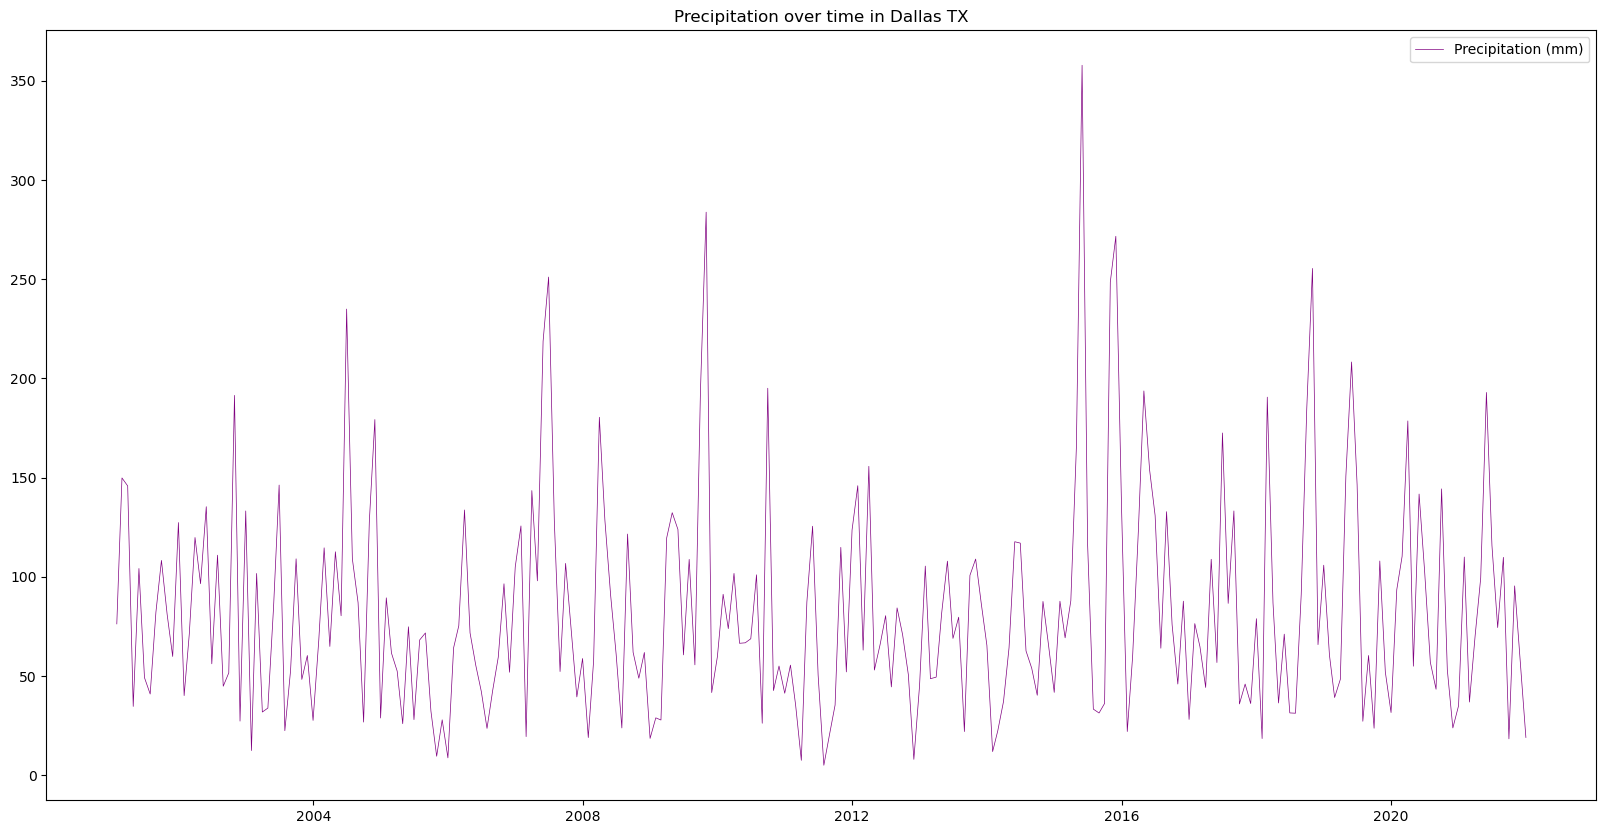

In [15]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10)) 

plt.plot(
    df["datetime"], # X-axis: datetime
    df["mean"], # Y-axis: Precipitation value
    color="purple", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="Precipitation (mm)", # Legend label
)

plt.title('Precipitation over time in Dallas TX')

# Display legend
plt.legend()

plt.show()